In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Custom utility methods
from src.EvaluateModels import EvaluatePreprocessors, EvaluateEstimators, EvaluatePipelines
from src.model_utils import make_categorical_encoding, plot_learning_curve, plot_validation_curve

# Models
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

# Pipelines and preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest

# Model selection and metrics
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn import set_config
set_config(display = 'diagram')


# Dev
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import data

In [2]:
train_df = pd.read_csv('../data/processed/training_data.csv', index_col = 0)
target = train_df.salary
train_df.drop(columns = 'salary', inplace=True)

In [3]:
train_df

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
58414,JUNIOR,HIGH_SCHOOL,NONE,WEB,14,84
902618,SENIOR,MASTERS,COMPSCI,SERVICE,24,86
778824,JANITOR,NONE,NONE,WEB,4,86
187593,SENIOR,HIGH_SCHOOL,NONE,WEB,0,42
574438,VICE_PRESIDENT,MASTERS,BUSINESS,AUTO,16,97
...,...,...,...,...,...,...
259179,VICE_PRESIDENT,DOCTORAL,BUSINESS,OIL,9,93
365839,CFO,DOCTORAL,BUSINESS,HEALTH,15,88
131933,SENIOR,MASTERS,COMPSCI,HEALTH,18,42
671158,SENIOR,DOCTORAL,PHYSICS,SERVICE,5,23


## Variables

In [4]:
# Specify ordinal levels for categorical variables
jobtype_ord_levels = ['JANITOR', 'JUNIOR',  'SENIOR', 'MANAGER', 'VICE_PRESIDENT', 'CFO', 'CTO', 'CEO']
degree_ord_levels = ['NONE', 'HIGH_SCHOOL', 'BACHELORS', 'MASTERS', 'DOCTORAL']
# industry levels ordered from lowest average salary to highest
industry_ord_levels = ['EDUCATION', 'SERVICE', 'AUTO', 'HEALTH', 'WEB', 'FINANCE', 'OIL']

# Scoring metric for modeling
SCORING_METRIC = 'neg_mean_squared_error'

# Basic Model - Linear Regression

I want to start modeling with something a little more basic and see how a linear regression measures up to the best baseline score that was found without ML.

**Best baseline score (MSE):** `371.22`

Plan:
1. Encode categorical variables
    - Ordinal encoding for `jobType` and `degree` variables
    - One hot encoding for `industry` and `major` variables
2. Scale numeric variables
    - use StandardScaler for `yearsExperience` and `milesFromMetropolis`
    
Starting out treating `jobType` and `degree` as ordinal. Depending on how the scores measure up, I can try other encodings and preprocessing. 

In [5]:
# Preprocessing with ColumnTransformer
basic_lr_preprocessing = ColumnTransformer([
    ('ordinal_encoding', OrdinalEncoder(categories=[jobtype_ord_levels, degree_ord_levels]), ['jobType', 'degree']),
    ('one_hot_encoding', OneHotEncoder(), ['major', 'industry']),
    ('std_scaler', StandardScaler(), ['yearsExperience', 'milesFromMetropolis'])
], remainder='passthrough')

# Model pipeline
basic_lr_model = Pipeline([
    ('preprocess', basic_lr_preprocessing),
    ('linear regression', LinearRegression())
])
basic_lr_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_encoding',
                                                  OrdinalEncoder(categories=[['JANITOR',
                                                                              'JUNIOR',
                                                                              'SENIOR',
                                                                              'MANAGER',
                                                                              'VICE_PRESIDENT',
                                                                              'CFO',
                                                                              'CTO',
                                                                              'CEO'],
                                                                             ['NONE',
                                                                              'HIGH_SCHOOL',
                                                                              'BACHELORS',
                                                                              'MASTERS',
                                                                              'DOCTORAL']]),
                                                  ['jobType', 'degree']),
                                                 ('one_hot_encoding',
                                                  OneHotEncoder(),
                                                  ['major', 'industry']),
                                                 ('std_scaler',
                                                  StandardScaler(),
                                                  ['yearsExperience',
                                                   'milesFromMetropolis'])])),
                ('linear regression', LinearRegression())])

In [6]:
# Run cross validation
basic_lr_scores = cross_validate(basic_lr_model, train_df, target, cv = 5, scoring = SCORING_METRIC, return_train_score = True)

print(f"Mean test score: {np.mean(basic_lr_scores['test_score'])}", end = '\n\n')
basic_lr_scores

Mean test score: -394.38290117364784



{'fit_time': array([1.54572606, 1.46879983, 1.50775766, 1.51774693, 1.50826216]),
 'score_time': array([0.19527698, 0.18928695, 0.20127082, 0.20326424, 0.20975423]),
 'test_score': array([-393.30608198, -396.3105107 , -394.56362714, -395.18530224,
        -392.54898381]),
 'train_score': array([-394.63886445, -393.88634722, -394.32206648, -394.16714741,
        -394.82603238])}

This linear regression's error is quite a bit higher than our best baseline score. I wonder if changing the encoding of the categorical variables will impact the results in a positive way.

## Test different categorical encodings

Plan:  
Test modeling different variables as ordinal encoding, and also test all one hot encoding

Candidates for ordinal encoding:
- jobType
- degree
- industry

`jobType` and `degree` I think are the ones that can be argued to have the most natural precedent for an ordering. 
- The different levels of `jobType` can be interpreted as needing different levels of: experience, qualifications, or responsibility on the job. (i.e. especially between the levels 'junior', 'senior', 'manager').
- Similarly with `degree` the natural ordering can be interpreted as the number of years of schooling. In this case it makes sense to order the levels as: `'none' < 'high school' < 'bachelors' < 'masters' < 'doctoral'`

As far as `industry` is concerned, it may be valid to argue that there is no real natural ordering between industries; can you really rank health versus finance industries? But the average salary of each of the levels of `industry` seem more spread out and cover a wider range of values than `degree`. So I can use the data to give a guess as to the order - might as well try it out.

I don't think it makes sense for `major` to be treated as ordinal here. Because there isn't a clear natural ording to the different majors. Additionally, there is no real data to give a direction at guessing/imposing an order on the levels of `major`. The average salary for the subgroups of `major` are too close together, plus the distributions of the salary for each of the levels of `major` are very much overlapped. And even during EDA we saw that top paying salaries across different industries have different majors, so it is hard to think of an ordering.
- I will only treat `major` as a nominal variable and use one hot encoding


**Preprocessing pipelines to test:**
1. single ordinal encoding  
    a. jobType  
    b. industry  
    c. degree  
2. double ordinal encoding  
    a. jobType & industry  
    b. industry & degree  
3. all 3 ordinal encoding
4. all one hot
5. first model (degree & jobType as ordinal)

In [8]:
# Keep a dictionary so that I can easily refer back to these column transformers later if necessary
# But I will also make a list of tuples to be fed into the evaluator classes 
categorical_encoding_pipelines = {
    # single ordinal encoding
    'jobType_ordinal': make_categorical_encoding(category_levels = [jobtype_ord_levels],
                                                 ord_cols = ['jobType'],
                                                 oh_cols = ['industry', 'degree', 'major']),
    'industry_ordinal': make_categorical_encoding(category_levels = [industry_ord_levels],
                                                  ord_cols = ['industry'],
                                                  oh_cols = ['jobType', 'degree', 'major']),
    'degree_ordinal': make_categorical_encoding(category_levels = [degree_ord_levels],
                                                ord_cols = ['degree'],
                                                oh_cols = ['industry', 'jobType', 'major']),
    
    # double ordinal encoding
    'jobType-industry_ordinal': make_categorical_encoding(category_levels = [jobtype_ord_levels, industry_ord_levels],
                                                          ord_cols = ['jobType', 'industry'],
                                                          oh_cols = ['degree', 'major']),
    'industry-degree_ordinal': make_categorical_encoding(category_levels = [industry_ord_levels, degree_ord_levels],
                                                         ord_cols = ['industry', 'degree'],
                                                         oh_cols = ['jobType', 'major']),
    
    # All 3 ordinal 
    'all_ordinal': make_categorical_encoding(category_levels = [jobtype_ord_levels, industry_ord_levels, degree_ord_levels],
                                             ord_cols = ['jobType', 'industry', 'degree'],
                                             oh_cols = ['major']),
    
    # All one hot
    'all_one_hot': make_categorical_encoding(category_levels = None, ord_cols = None,
                                             oh_cols = ['jobType', 'degree', 'industry', 'major']),
    
    # First model - basic lr (jobType & degree ordinal) 
    'basic_lr_(first model)': basic_lr_preprocessing
    
}

# list of test arrays
categorical_encoding_list = [(name, transformer) for name, transformer in categorical_encoding_pipelines.items()]

In [8]:
find_best_categorical_encoding = EvaluatePreprocessors(preprocessors = categorical_encoding_list,
                                                       estimator = LinearRegression(),
                                                       scoring = SCORING_METRIC)

find_best_categorical_encoding.run(train_df, target)

::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Best model found:
Pipeline(steps=[('all_one_hot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encoding',
                                                  OneHotEncoder(),
                                                  ['jobType', 'degree',
                                                   'industry', 'major']),
                                                 ('std_scaler',
                                                  StandardScaler(),
                                                  ['yearsExperience',
                                                   'milesFromMetropolis'])])),
                ('estimator', LinearRegression())])

Model score (using 'neg_mean_squared_error')
-384.40224675582164



,test_score,train_score,fit_time,score_time
all_one_hot,-384.402247,-384.377823,1.412372,0.209958
degree_ordinal,-384.580781,-384.557766,1.410672,0.221447
industry_ordinal,-386.794762,-386.774068,1.485694,0.215850
industry-degree_ordinal,-386.973211,-386.953954,1.442635,0.215551
jobType_ordinal,-394.090058,-394.073960,1.441339,0.222244
basic_lr_(first model),-394.382901,-394.368092,1.517460,0.200868
jobType-industry_ordinal,-396.491995,-396.478983,1.471216,0.208557
all_ordinal,-396.784029,-396.772258,1.293513,0.190380


The categorical encoding that worked the best is using one hot for all the variables, with a score of `384.40`. But not quite as low as the baseline score.

#### after linear regression
- test out ridge/lasso with the best preprocessing
- try with feature selection with the best of ridge/lasso
- test against SGDRegressor
- the best model from the above test against gradient boosting and tree methods

- hyperperameter tune


# Test other models

**Plan:**  
Explore how other models, with basic parameter settings, measure up to the linear regression model. Before diving into getting better performance out of the linear regression model I will see if there is another type of model which seems to greatly outperform the rest, and could be more fruitful to spend time on.

**Models to test:**
- SDGRegressor
    - The linear regression seems to have more of a bias than variance issue, this may be able to fit the data better
- Random forest
- XGBoost gradient boosted trees

#### New categorical encoding to help for tree based methods
After an initial test with random forest, using all one hot encoding seems to have a very negative performance in terms of training time and squared error

This encoding uses the default OrdinalEncoder labeling and doesn't scale the `yearsExperience` or `milesFromMetropolis`

In [40]:
ordinal_no_scaling_pp = ColumnTransformer([('ordinal encoding', OrdinalEncoder(), ['jobType', 'degree', 'industry', 'major'])], remainder='passthrough')
ordinal_no_scaling_pp

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinal encoding', OrdinalEncoder(),
                                 ['jobType', 'degree', 'industry', 'major'])])

In [41]:
# New models
random_forest = Pipeline([
    ('categorical_encoding', ordinal_no_scaling_pp),
    ('rf', RandomForestRegressor(max_depth=20, n_estimators = 150, n_jobs = -1, min_samples_leaf=10))
])

xg_boost = Pipeline([
    ('categorical_encoding', categorical_encoding_pipelines['all_one_hot']),
    ('xbg', XGBRegressor())
])

sgd_regressor = Pipeline([
    ('categorical_encoding', categorical_encoding_pipelines['all_one_hot']),
    ('sgd_regressor', SGDRegressor())
])

new_model_pipelines = [
    ('rf', random_forest),
    ('xgb', xg_boost),
    ('sgd_regressor', sgd_regressor)
]

In [43]:
test_new_models = EvaluatePipelines(new_model_pipelines, scoring = SCORING_METRIC)
test_new_models.run(train_df, target, verbose = True)

------------------------------
Finished training: rf
Test score  : -375.3301843570048
Train score : -302.6059283697493

------------------------------
Finished training: xgb
Test score  : -358.49743819860595
Train score : -352.25551074759744

------------------------------
Finished training: sgd_regressor
Test score  : -384.5905336575519
Train score : -384.57045782847615

::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Best model found:
Pipeline(steps=[('categorical_encoding',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encoding',
                                                  OneHotEncoder(),
                                                  ['jobType', 'degree',
                                                   'industry', 'major']),
                                                 ('std_scaler',
                                                  StandardScaler(),
                              

,test_score,train_score,fit_time,score_time
xgb,-358.497438,-352.255511,21.978652,0.355188
rf,-375.330184,-302.605928,71.441053,2.132487
sgd_regressor,-384.590534,-384.570458,5.667595,0.210059


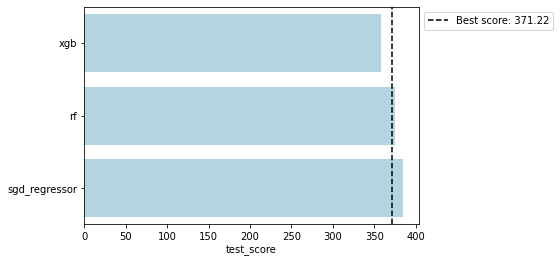

In [45]:
# Plot the results with a reference to the best score before this test (baseline score)
test_new_models.plot_results(best_score = 371.22)

**Results:**
- xgboost: 
    - Performed the best on the validation set
    - Pretty reasonable train time, which means parameter tuning should be quicker than random forest
    - Has some variance that should be paid attention to with further parameter tuning
- randomforest: 
    - Fits the training data better and has a bit of a variance/ overfitting issue. But with some regularization it may generalize well
    - Has a longer train time, and might take awhile to comprehensively parameter tune.
- SGDRegressor:
    - About the same error as linear regression. Also has more of a bias problem than variance, so tweaking the regularization parameters will probably not help as much here
    - Still doesn't beat the baseline score. Perhaps with some more training iterations, but this model doesn't seem as fruitful to spend time on over the other two

# Randomforest

**Plan:**  
Explore regularization options to reduce variance and hopefully improve cross validation scores.

### Learning curve

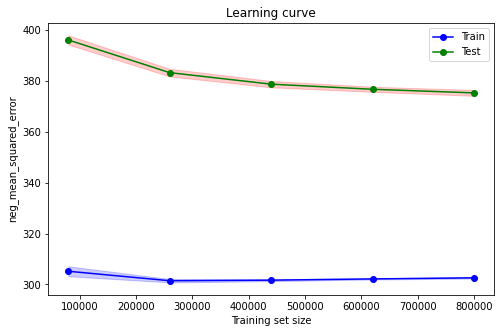

In [46]:
plot_learning_curve(random_forest, train_df, target, scoring = SCORING_METRIC)

### Validation Curves

Since the training time is a little longer with this model, I will start looking at validation curves for individual parameter ranges before grid searching multiple parameters at once. So that I may be able to get quicker feedback, and narrow down a grid search to something more reasonable.

**max_depth**: Reducing the depth of the trees in the forest will make the model less complex and hopefully reduce variance

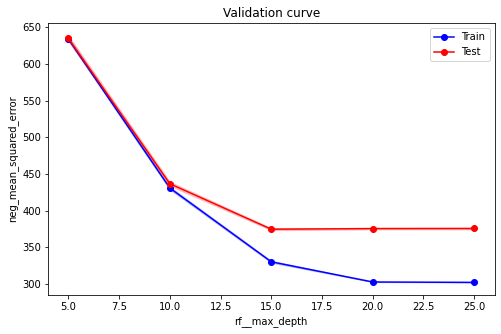

In [49]:
plot_validation_curve(random_forest, train_df, target, param_name = 'rf__max_depth', param_range = [5, 10, 15, 20, 25], scoring = SCORING_METRIC)

Having a `max_depth` of greater than 15 doesn't look to make any significant difference in the test score; and having a depth greater than 20 doesn't look to make a difference for the training scores

**min_samples_leaf:**

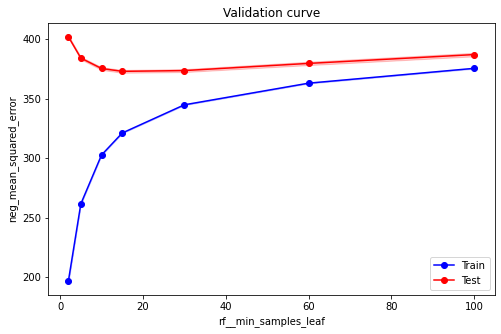

In [50]:
plot_validation_curve(random_forest, train_df, target, param_name = 'rf__min_samples_leaf', param_range = [2, 5, 10, 15, 30, 60, 100], scoring = SCORING_METRIC)

**max_features:**

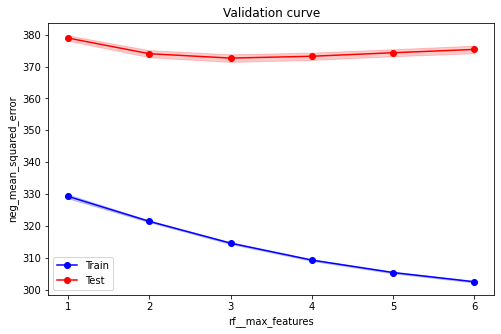

In [52]:
plot_validation_curve(random_forest, train_df, target, param_name = 'rf__max_features', param_range = [1, 2, 3, 4, 5, 6], scoring = SCORING_METRIC)

In [57]:
improved_randomforest = Pipeline([
    ('categorical_encoding', ordinal_no_scaling_pp),
    ('rf', RandomForestRegressor(max_depth = 15, n_estimators = 200, n_jobs = -1, min_samples_leaf = 30,
                                 max_features=3))
])

cross_validate(improved_randomforest, train_df, target, scoring = SCORING_METRIC, return_train_score=True, cv = 5)

{'fit_time': array([58.2674334 , 56.79916   , 56.21321273, 56.69419694, 56.72207308]),
 'score_time': array([1.40599084, 1.43576956, 1.40172768, 1.40927148, 1.43525219]),
 'test_score': array([-375.66822813, -378.78360808, -377.62111818, -377.18601794,
        -374.87943573]),
 'train_score': array([-356.55751135, -356.0535512 , -355.8373449 , -356.0431055 ,
        -356.65371992])}

In [55]:
# max_depth = 15, n_estimators = 150, n_jobs = -1, min_samples_leaf = 30
np.mean([-374.01550855, -377.72702155, -375.60494544, -375.15366326,
        -373.41567975])

-375.18336371

In [58]:
# max_depth = 15, n_estimators = 200, n_jobs = -1, min_samples_leaf = 30
np.mean([-373.96493233, -377.67612903, -375.68171097, -375.19576729,
        -373.52104245])

-375.207916414

# XGBoost

In [48]:
random_forest.get_params()

{'memory': None,
 'steps': [('categorical_encoding',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('ordinal encoding', OrdinalEncoder(),
                                    ['jobType', 'degree', 'industry', 'major'])])),
  ('rf',
   RandomForestRegressor(max_depth=20, min_samples_leaf=10, n_estimators=150,
                         n_jobs=-1))],
 'verbose': False,
 'categorical_encoding': ColumnTransformer(remainder='passthrough',
                   transformers=[('ordinal encoding', OrdinalEncoder(),
                                  ['jobType', 'degree', 'industry', 'major'])]),
 'rf': RandomForestRegressor(max_depth=20, min_samples_leaf=10, n_estimators=150,
                       n_jobs=-1),
 'categorical_encoding__n_jobs': None,
 'categorical_encoding__remainder': 'passthrough',
 'categorical_encoding__sparse_threshold': 0.3,
 'categorical_encoding__transformer_weights': None,
 'categorical_encoding__transformers': [('ordinal encoding',
   Ordina